In [9]:
import gzip
import json
import pandas as pd
import numpy as np
from scipy.sparse import coo_matrix
import torch
from torch_geometric.data import Data
from torch_geometric.utils import from_scipy_sparse_matrix
from torch_geometric.transforms import RandomNodeSplit
from sklearn.model_selection import train_test_split
from torch_geometric.nn import GCNConv
from torch_geometric.nn.conv import GATConv
from torch.nn import Linear, ModuleList, Dropout, BatchNorm1d
import torch.nn.functional as F
from torch.optim import Adam
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from torch_geometric.utils import subgraph
import matplotlib.pyplot as plt
import tqdm as tqdm
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [2]:
with gzip.open('../data/xbar/1/xbar.json.gz','rb') as f:
    design = json.loads(f.read().decode('utf-8'))

instances = pd.DataFrame(design['instances'])
nets = pd.DataFrame(design['nets'])

conn=np.load('../data/xbar/1/xbar_connectivity.npz')
A = coo_matrix((conn['data'], (conn['row'], conn['col'])), shape=conn['shape'])
A = A.__mul__(A.T)
def buildBST(array,start=0,finish=-1):
    if finish<0:
        finish = len(array)
    mid = (start + finish) // 2
    if mid-start==1:
        ltl=start
    else:
        ltl=buildBST(array,start,mid)
    
    if finish-mid==1:
        gtl=mid
    else:
        gtl=buildBST(array,mid,finish)
        
    return((array[mid],ltl,gtl))

congestion_data = np.load('../data/xbar/1/xbar_congestion.npz')
xbst=buildBST(congestion_data['xBoundaryList'])
ybst=buildBST(congestion_data['yBoundaryList'])
demand = np.zeros(shape = [instances.shape[0],])

def getGRCIndex(x,y,xbst,ybst):
    while (type(xbst)==tuple):
        if x < xbst[0]:
            xbst=xbst[1]
        else:
            xbst=xbst[2]
            
    while (type(ybst)==tuple):
        if y < ybst[0]:
            ybst=ybst[1]
        else:
            ybst=ybst[2]
            
    return ybst, xbst


for k in range(instances.shape[0]):
    # print(k)
    xloc = instances.iloc[k]['xloc']; yloc = instances.iloc[k]['yloc']
    i,j=getGRCIndex(xloc,yloc,xbst,ybst)
    d = 0 
    for l in list(congestion_data['layerList']): 
        lyr=list(congestion_data['layerList']).index(l)
        d += congestion_data['demand'][lyr][i][j]
    demand[k] = d
        
instances['routing_demand'] = demand

In [3]:
torch.manual_seed(42) # for replication
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X = torch.tensor(instances[['xloc', 'yloc', 'cell', 'orient']].values)
y = torch.tensor(instances['routing_demand'].values)
ei = from_scipy_sparse_matrix(A)
edge_index = ei[0]
data = Data(x=X, edge_index=edge_index, y=y)
split = RandomNodeSplit(num_splits=1, num_val=0.0, num_test=0.3)
split_data = split(data)
train_mask = split_data.train_mask
test_mask = split_data.test_mask

train = torch.argwhere(split_data.train_mask).reshape(-1)
test = torch.argwhere(split_data.test_mask).reshape(-1)
train_mapping = {a.item():b for a,b in zip(train, range(train.shape[0]))}
test_mapping = {a.item():b for a,b in zip(test, range(test.shape[0]))}
train_subgraph = subgraph(train_mask, data.edge_index, relabel_nodes=True, num_nodes=data.num_nodes)
test_subgraph = subgraph(test_mask, data.edge_index, relabel_nodes=True, num_nodes=data.num_nodes)
final_train = Data(x=data.x[train_mask], edge_index=train_subgraph[0], y=data.y[train_mask])
final_test = Data(x=data.x[test_mask], edge_index=test_subgraph[0], y=data.y[test_mask])

In [4]:
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(final_train.x.numpy(), final_train.y.numpy().ravel())
predictions = rf_regressor.predict(final_test.x.numpy())
mse = mean_squared_error(final_test.y.numpy().ravel(), predictions)
r2 = r2_score(final_test.y.numpy().ravel(), predictions)
print(f'Mean Squared Error (MSE): {mse}')
print(f'R-squared Score: {r2}')

Mean Squared Error (MSE): 5.8637880269814495
R-squared Score: 0.715635348801225


In [5]:
instances

,name,id,xloc,yloc,cell,orient,routing_demand
0,clk_gate_out_reg/latch,0,41984,44544,23,0,20.0
1,clk_gate_out_reg_0/latch,1,41984,47616,23,6,23.0
2,clk_gate_out_reg_1/latch,2,44160,44544,23,0,23.0
3,clk_gate_out_reg_2/latch,3,44160,47616,23,0,22.0
4,clk_gate_out_reg_3/latch,4,46336,47616,23,0,21.0
...,...,...,...,...,...,...,...
3947,U4123,3947,21888,53760,42,4,31.0
3948,U4125,3948,33664,66048,42,0,30.0
3949,U4128,3949,23296,66048,34,0,27.0
3950,ZCTSBUF_205_132,3950,40576,44544,11,0,28.0


In [6]:
GRC_widths = instances.groupby('cell')['xloc'].max() - instances.groupby('cell')['xloc'].min()
GRC_heights = instances.groupby('cell')['yloc'].max() - instances.groupby('cell')['yloc'].min()
GRC_area = GRC_widths * GRC_heights
GRC_area = GRC_area.replace(0, np.nan)  # Replace 0 areas with NaN
pin_density = instances.groupby('cell')['id'].count() / GRC_area
pin_density = pin_density.fillna(0)
pin_df = pd.DataFrame(pin_density.rename('pin_density')).reset_index()

In [7]:
instances = instances.merge(pin_df, how='left', on='cell')
instances['degree'] = np.array(A.sum(axis=1)).flatten()

In [8]:
instances

,name,id,xloc,yloc,cell,orient,routing_demand,pin_density,degree
0,clk_gate_out_reg/latch,0,41984,44544,23,0,20.0,2.991919e-07,681
1,clk_gate_out_reg_0/latch,1,41984,47616,23,6,23.0,2.991919e-07,681
2,clk_gate_out_reg_1/latch,2,44160,44544,23,0,23.0,2.991919e-07,681
3,clk_gate_out_reg_2/latch,3,44160,47616,23,0,22.0,2.991919e-07,681
4,clk_gate_out_reg_3/latch,4,46336,47616,23,0,21.0,2.991919e-07,681
...,...,...,...,...,...,...,...,...,...
3947,U4123,3947,21888,53760,42,4,31.0,8.247994e-08,276
3948,U4125,3948,33664,66048,42,0,30.0,8.247994e-08,276
3949,U4128,3949,23296,66048,34,0,27.0,5.496090e-08,180
3950,ZCTSBUF_205_132,3950,40576,44544,11,0,28.0,0.000000e+00,139


In [10]:
ohe = OneHotEncoder()
transformed = ohe.fit_transform(instances[['cell']])
ohe_df = pd.DataFrame.sparse.from_spmatrix(transformed)
ohe_df

OneHotEncoder()

In [27]:
instances = instances.merge(ohe_df, left_index=True, right_index=True).drop(columns=['cell', 'name', 'id'])
instances

,xloc,yloc,orient,routing_demand,pin_density,degree,0,1,2,3,4,5,6,7,8,9,10,11,12
0,41984,44544,0,20.0,2.991919e-07,681,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,41984,47616,6,23.0,2.991919e-07,681,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,44160,44544,0,23.0,2.991919e-07,681,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,44160,47616,0,22.0,2.991919e-07,681,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,46336,47616,0,21.0,2.991919e-07,681,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3947,21888,53760,4,31.0,8.247994e-08,276,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3948,33664,66048,0,30.0,8.247994e-08,276,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3949,23296,66048,0,27.0,5.496090e-08,180,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3950,40576,44544,0,28.0,0.000000e+00,139,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
#torch.manual_seed(42) # for replication
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X = torch.tensor(instances.drop('routing_demand', axis=1).values, dtype=torch.float)
y = torch.tensor(instances['routing_demand'].values, dtype=torch.float)
ei = from_scipy_sparse_matrix(A)
edge_index = ei[0].to(dtype=torch.long) 
data = Data(x=X, edge_index=edge_index, y=y)
split = RandomNodeSplit(num_splits=1, num_val=0.0, num_test=0.3)
split_data = split(data)
train_mask = split_data.train_mask
test_mask = split_data.test_mask

train = torch.argwhere(split_data.train_mask).reshape(-1)
test = torch.argwhere(split_data.test_mask).reshape(-1)
train_mapping = {a.item():b for a,b in zip(train, range(train.shape[0]))}
test_mapping = {a.item():b for a,b in zip(test, range(test.shape[0]))}
train_subgraph = subgraph(train_mask, data.edge_index, relabel_nodes=True, num_nodes=data.num_nodes)
test_subgraph = subgraph(test_mask, data.edge_index, relabel_nodes=True, num_nodes=data.num_nodes)
final_train = Data(x=data.x[train_mask], edge_index=train_subgraph[0], y=data.y[train_mask]).to(device).to(device)
final_test = Data(x=data.x[test_mask], edge_index=test_subgraph[0], y=data.y[test_mask]).to(device)

In [31]:
class GCN(torch.nn.Module):
    def __init__(self, num_features, num_hidden_layers, hidden_channels, dropout_rate=0.5, activation_function='relu'):
        super(GCN, self).__init__()
        self.gcn = GATConv(num_features, hidden_channels)
        self.hidden_layers = ModuleList([])
        self.batch_norms =  ModuleList([])
        for _ in range(num_hidden_layers):
            self.hidden_layers.append(GATConv(hidden_channels, hidden_channels))
            self.batch_norms.append(BatchNorm1d(hidden_channels))
        self.dropout = Dropout(dropout_rate)
        self.out = Linear(hidden_channels, 1)
        self.activation_function = activation_function

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        if self.activation_function == 'relu':
            activation = F.relu
        elif self.activation_function == 'leaky_relu':
            activation = F.leaky_relu
        elif self.activation_function == 'elu':
            activation = F.elu
        else:
            raise ValueError("Unsupported activation function")

        x = activation(self.gcn(x, edge_index))
        for layer, norm in zip(self.hidden_layers, self.batch_norms):
            x = self.dropout(x)
            x = layer(x, edge_index)
            x = norm(x)
            x = activation(x)
        x = self.out(x)
        return x

In [32]:
def train(model, data, test_data, optimizer_choice='adam', lr=0.01, epochs=200):
    data = data.to(device)
    criterion = torch.nn.MSELoss()
    if optimizer_choice == 'adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)
    elif optimizer_choice == 'sgd':
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    elif optimizer_choice == 'rmsprop':
        optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
    else:
        raise ValueError("Unsupported optimizer")

    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        z = model(data)
        z = z.to(device)
        loss = criterion(z.squeeze(), data.y.float())
        loss.backward()
        optimizer.step()
        scheduler.step()

        if epoch % 10 == 0:
            print(f'Epoch {epoch:>3} | Loss: {loss:.2f}')
            # print(test_mse(model,test_data))

def test_mse_with_errors(model, test_data):
    model.eval()
    with torch.no_grad():
        test_data = test_data.to(device)
        predictions = model(test_data)
        errors = (predictions.squeeze() - test_data.y.float()).cpu().numpy()  # Calculate individual errors
        mse = F.mse_loss(predictions.squeeze(), test_data.y.float()).item()  # Calculate MSE

    return mse, errors

In [33]:
# one_layer_model = GCN(num_features=final_train.x.shape[1], num_hidden_layers=0, hidden_channels=768).to(device)
# train(one_layer_model, final_train, final_test)
# print(test_mse(one_layer_model, final_test)) 

Epoch   0 | Loss: 665.66
Epoch  10 | Loss: 550.36
Epoch  20 | Loss: 445.20
Epoch  30 | Loss: 361.20
Epoch  40 | Loss: 275.97
Epoch  50 | Loss: 199.16
Epoch  60 | Loss: 213.26
Epoch  70 | Loss: 155.04
Epoch  80 | Loss: 122.77
Epoch  90 | Loss: 102.19
Epoch 100 | Loss: 79.50
Epoch 110 | Loss: 69.07
Epoch 120 | Loss: 62.14
Epoch 130 | Loss: 56.22
Epoch 140 | Loss: 62.13
Epoch 150 | Loss: 45.43
Epoch 160 | Loss: 48.22
Epoch 170 | Loss: 44.90
Epoch 180 | Loss: 40.89
Epoch 190 | Loss: 39.78
Epoch 200 | Loss: 44.41
Epoch 210 | Loss: 40.99
Epoch 220 | Loss: 41.97
Epoch 230 | Loss: 40.44
Epoch 240 | Loss: 40.00
Epoch 250 | Loss: 40.69
Epoch 260 | Loss: 38.66
Epoch 270 | Loss: 33.35
Epoch 280 | Loss: 38.02
Epoch 290 | Loss: 33.10
Epoch 300 | Loss: 35.40
Epoch 310 | Loss: 30.56
Epoch 320 | Loss: 37.88
Epoch 330 | Loss: 32.57
Epoch 340 | Loss: 34.20
Epoch 350 | Loss: 33.56
Epoch 360 | Loss: 32.21
Epoch 370 | Loss: 29.56
Epoch 380 | Loss: 33.37
Epoch 390 | Loss: 32.25
Epoch 400 | Loss: 33.07
Epoch 

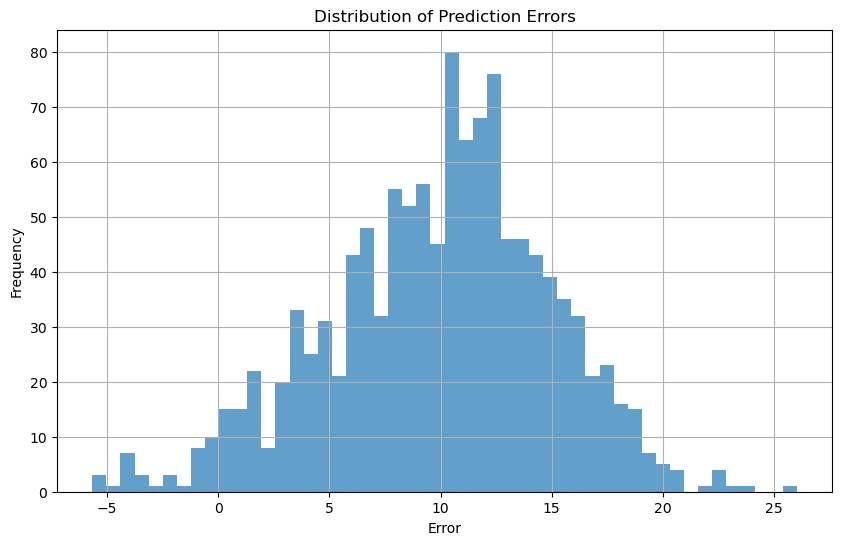

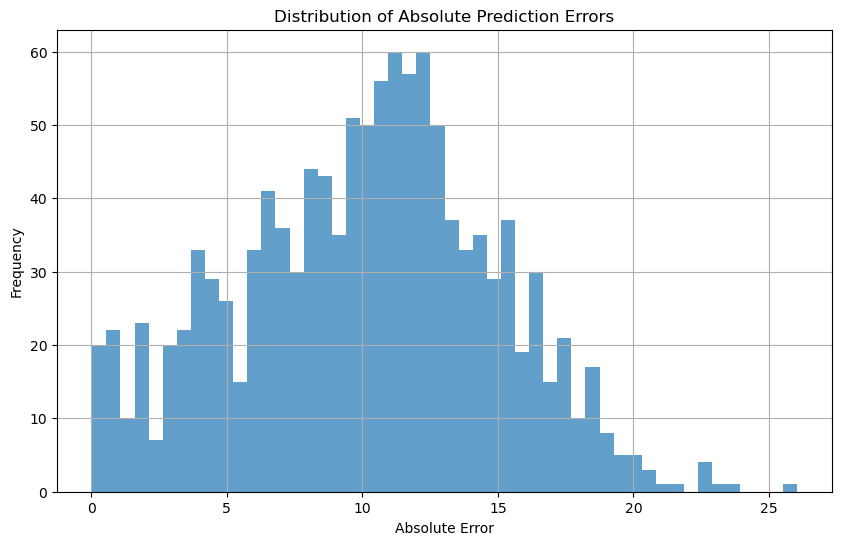

In [34]:
two_layer_model = GCN(num_features=final_train.x.shape[1], 
            num_hidden_layers=3,  # Increase model complexity carefully
            hidden_channels=1200, 
            dropout_rate=0.45,  # Adjust dropout rate
            activation_function='relu').to(device)
train(two_layer_model, final_train, final_test,optimizer_choice='adam', lr=0.001 / 2, epochs=500)
mse, errors = test_mse_with_errors(two_layer_model, final_test)
print(f"Test MSE: {mse}")


plt.figure(figsize=(10, 6))
plt.hist(errors, bins=50, alpha=0.7)
plt.title("Distribution of Prediction Errors")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


plt.figure(figsize=(10, 6))
plt.hist(np.abs(errors), bins=50, alpha=0.7)
plt.title("Distribution of Absolute Prediction Errors")
plt.xlabel("Absolute Error")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [145]:
import torch.nn as nn
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [104]:
def evaluate_mlp(model, features, labels):
    model.eval()
    with torch.no_grad():
        predictions = model(features)
        mse = F.mse_loss(predictions.squeeze(), labels)
    return mse.item()

def train_mlp(model, features, labels, test_features, test_labels, epochs=100, learning_rate=0.01):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = torch.nn.MSELoss()
    
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(features)
        loss = criterion(outputs.squeeze(), labels)
        
        # Backward and optimize
        loss.backward()
        optimizer.step()
        
        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')
            print(evaluate_mlp(mlp_model, test_features, test_labels))

# Prepare data
features = final_train.x
labels = final_train.y.float()

# Initialize and train the MLP
test_features = final_test.x.to(device)
test_labels = final_test.y.float().to(device)
mlp_model = MLP(input_dim=features.shape[1], hidden_dim=100, output_dim=1).to(device)
train_mlp(mlp_model, features.to(device), labels.to(device), test_features.to(device), test_labels.to(device), epochs=5000, learning_rate=0.005)

Epoch 0, Loss: 33216292.0
1936690.125
Epoch 10, Loss: 2750961.0
285544.625
Epoch 20, Loss: 2017623.25
2067298.5
Epoch 30, Loss: 33553.55078125
217070.984375
Epoch 40, Loss: 208577.015625
58813.1953125
Epoch 50, Loss: 113525.8515625
90008.609375
Epoch 60, Loss: 29683.44140625
38986.09765625
Epoch 70, Loss: 10110.3818359375
15114.419921875
Epoch 80, Loss: 4906.6689453125
7038.6015625
Epoch 90, Loss: 3409.84033203125
3865.6953125
Epoch 100, Loss: 2350.976318359375
2233.921142578125
Epoch 110, Loss: 1616.89404296875
1481.134521484375
Epoch 120, Loss: 1170.3365478515625
1199.4595947265625
Epoch 130, Loss: 977.71630859375
1038.6510009765625
Epoch 140, Loss: 845.7334594726562
875.941650390625
Epoch 150, Loss: 733.633056640625
761.0613403320312
Epoch 160, Loss: 656.839599609375
680.7344360351562
Epoch 170, Loss: 593.1763916015625
616.171142578125
Epoch 180, Loss: 540.6138916015625
562.6934204101562
Epoch 190, Loss: 496.363525390625
516.8653564453125
Epoch 200, Loss: 458.62640380859375
478.3507

In [105]:
# Evaluate MLP
mlp_test_mse = evaluate_mlp(mlp_model, test_features, test_labels)

print(f'MLP Test MSE: {mlp_test_mse}')


MLP Test MSE: 64552.5390625


In [95]:
three_layer_model = GCN(num_features=final_train.x.shape[1], num_hidden_layers=2, hidden_channels=768).to(device)
train(three_layer_model, final_train)
print(test_mse(three_layer_model, final_test))

Epoch   0 | Loss: 685.69
Epoch  10 | Loss: 111.48
Epoch  20 | Loss: 44.85
Epoch  30 | Loss: 29.47
Epoch  40 | Loss: 26.60
Epoch  50 | Loss: 22.21
Epoch  60 | Loss: 21.04
Epoch  70 | Loss: 20.86
Epoch  80 | Loss: 20.49
Epoch  90 | Loss: 20.93
Epoch 100 | Loss: 18.55
Epoch 110 | Loss: 18.71
Epoch 120 | Loss: 18.36
Epoch 130 | Loss: 17.69
Epoch 140 | Loss: 17.77
Epoch 150 | Loss: 17.03
Epoch 160 | Loss: 17.84
Epoch 170 | Loss: 16.56
Epoch 180 | Loss: 17.19
Epoch 190 | Loss: 17.24
36.4619026184082


In [97]:
three_layer_model = GCN(num_features=final_train.x.shape[1], num_hidden_layers=4, hidden_channels=768).to(device)
train(three_layer_model, final_train)
print(test_mse(three_layer_model, final_test))

Epoch   0 | Loss: 673.03
Epoch  10 | Loss: 82.04
Epoch  20 | Loss: 30.03
Epoch  30 | Loss: 22.37
Epoch  40 | Loss: 21.19
Epoch  50 | Loss: 18.74
Epoch  60 | Loss: 17.05
Epoch  70 | Loss: 17.66
Epoch  80 | Loss: 17.51
Epoch  90 | Loss: 16.63
Epoch 100 | Loss: 16.34
Epoch 110 | Loss: 15.61
Epoch 120 | Loss: 15.44
Epoch 130 | Loss: 15.41
Epoch 140 | Loss: 15.17
Epoch 150 | Loss: 15.00
Epoch 160 | Loss: 15.27
Epoch 170 | Loss: 14.89
Epoch 180 | Loss: 15.17
Epoch 190 | Loss: 14.41
41.53360366821289


In [12]:
def baseline_model_pytorch(data):
    device = "cuda" if torch.cuda.is_available() else "cpu"  # Automatically choose the device
    data = data.to(device)  # Ensure the data is on the correct device
    train_mean = data.y.float().mean()  # Calculate mean over all data.y
    baseline_predictions = torch.full_like(data.y, train_mean, device=device)  # Ensure this tensor is on GPU
    mse = F.mse_loss(baseline_predictions, data.y.float())  # Calculate MSE over all data.y
    return mse.item()

In [13]:
train_mse_baseline = baseline_model_pytorch(final_train)
test_mse_baseline = baseline_model_pytorch(final_test)

print(f"Baseline Training MSE: {train_mse_baseline}")
print(f"Baseline Test MSE: {test_mse_baseline}")

Baseline Training MSE: 20.35999870300293
Baseline Test MSE: 20.62066650390625
